# Investigating the feasibility of building a model to predict terminal category membership

Created by: Grace Patlewicz<br>
Date: 16 May 2024<br>
This notebook investigates the potential of building a ML model to predict terminal category membership in lieu of having to recluster each time. Inputs include the secondary category designations and Morgan fingerprints.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import sys

In [4]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [5]:
from model_functions import *

In [6]:
df = pd.read_excel(interim_dir+'final_revised_universe_wmappingdict_130524.xlsx', index_col = [0])

In [7]:
df.shape

(15525, 148)

In [8]:
from sklearn.model_selection import cross_validate,KFold,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

In [9]:
data = mk_fp(df)

In [10]:
data.shape

(15525, 1024)

In [11]:
data.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
IROQAHVXXUQBOS-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
DTXSID90897582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID90896257,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
DTXSID90896196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
DTXSID90896095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
df['group_str']=[str(e) for e in df['group'] ]

In [13]:
df1 = df.set_index('dtxsid')
y1 = df1[['group_str', 'category', 'chain_length']]

In [14]:
df2 = pd.concat([data, y1], axis = 1)

In [15]:
df2 = df2.sample(frac = 1)

In [16]:
df2

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023,group_str,category,chain_length
BHWRNYAZMPBJEY-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Aromatic PFASs', 'lt7', 3.0, nan)",Aromatic PFASs,5
DTXSID501035029,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,"('PFAAs', 'lt7', 2.0, nan)",PFAAs,5
DTXSID50896556,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Other PFASs, cyclic', 'lt7', 1.0, 1.0)","Other PFASs, cyclic",3
DTXSID901035233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('others', 'lt7', 3.0, 1.0)",others,3
DTXSID001045570,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,"('PFAA precursors, cyclic', 'lt7', 3.0, 2.0)","PFAA precursors, cyclic",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID401348247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Aromatic PFASs', 'lt7', 4.0, 3.0)",Aromatic PFASs,6
DTXSID101245602,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,"('Aromatic PFASs', 'lt7', 1.0, nan)",Aromatic PFASs,2
DTXSID001023396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,"('others', 'gte7', nan, nan)",others,8
DTXSID60465994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,"('others', 'lt7', 1.0, nan)",others,6


In [17]:
from collections import Counter

In [18]:
df2['group_str'].value_counts()

('Aromatic PFASs', 'lt7', 2.0, 5.0)            1238
('PASF-based substances', 'gte7', nan, nan)     770
('PASF-based substances', 'lt7', nan, nan)      697
('Aromatic PFASs', 'lt7', 2.0, 2.0)             592
('Aromatic PFASs', 'gte7', nan, nan)            584
                                               ... 
('PFAAs, cyclic', 'lt7', 3.0, 1.0)                4
('Other PFASs, cyclic', 'gte7', 1.0, nan)         2
('Other PFASs, cyclic', 'gte7', 3.0, nan)         2
('unclassified', 'lt7', 2.0, 2.0)                 2
('PFAAs, cyclic', 'gte7', nan, nan)               1
Name: group_str, Length: 128, dtype: int64

In [19]:
counts = Counter([molecule for molecule in df2['group_str']])

In [20]:
len( [group for group in counts if counts[group]>=10])

117

In [21]:
small_groups = [group for group in counts if counts[group]<10]

In [22]:
len(small_groups)

11

In [23]:
df2['group'] = df2['group_str'].apply(lambda x: 'misc_category' if x in small_groups else x)

In [24]:
#df2.group.value_counts().reset_index()[df2.group.value_counts().reset_index()['group'] <50]

In [25]:
cats = set(df2['group'].sort_values().tolist())

In [26]:
my_dict = {}
sorted_cats = sorted(cats)  # Sort the categories

for i, e in enumerate(sorted_cats, 1):
    a = f'Category{i}'
    my_dict[e] = a
    

In [27]:
#my_dict

In [28]:
df2['terminal_category'] = df2['group'].replace(my_dict)

In [29]:
df2.terminal_category.value_counts()

Category7      1238
Category30      770
Category31      697
Category4       592
Category1       584
               ... 
Category99       12
Category81       11
Category115      11
Category104      10
Category102      10
Name: terminal_category, Length: 118, dtype: int64

In [30]:
y = df2['terminal_category']

In [31]:
X = df2.drop(['group_str', 'group', 'terminal_category'], axis = 1)

In [32]:
X.shape

(15525, 1026)

In [33]:
X.iloc[:,-3:]

,mrgn_1023,category,chain_length
BHWRNYAZMPBJEY-UHFFFAOYSA-N,0,Aromatic PFASs,5
DTXSID501035029,0,PFAAs,5
DTXSID50896556,0,"Other PFASs, cyclic",3
DTXSID901035233,0,others,3
DTXSID001045570,0,"PFAA precursors, cyclic",2
...,...,...,...
DTXSID401348247,0,Aromatic PFASs,6
DTXSID101245602,0,Aromatic PFASs,2
DTXSID001023396,1,others,8
DTXSID60465994,1,others,6


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [35]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [36]:
from sklearn import set_config
set_config(display='diagram')

In [37]:
X['category'] = X['category'].astype('category')

In [38]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

numerical_columns_selector = selector(dtype_include=int)
categorical_columns_selector = selector(dtype_include='category')

In [39]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [40]:
numerical_columns[-1]

'chain_length'

In [41]:
from sklearn.preprocessing import OrdinalEncoder

In [42]:
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)

In [43]:
numerical_pipe = StandardScaler()

In [44]:
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=True,
)

In [45]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [46]:
from sklearn.pipeline import Pipeline

In [47]:
pipe = Pipeline([('preprocessing', preprocessing), ('model',rfc)])

In [48]:
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['category']),
                                                 ('num', StandardScaler(),
                                                  ['mrgn_0', 'mrgn_1', 'mrgn_2',
                                                   'mrgn_3', 'mrgn_4', 'mrgn_5',
                                                   'mrgn_6', 'mrgn_7', 'mrgn_8',
                                                   'mrgn_9', 'mrgn_10',
                                                   'mrgn_11', 'mrgn_12',
                                                   'mrgn_13', 'mrgn_14',
                                                   'mrgn_15', 'mrgn_16',
                                                   'mrgn_17', 'mrgn_18',
                                                   'mrgn_19', 'mrgn_20',
                                                   'mrgn_21', 'mrgn_22',
                                                   'mrgn_23', 'mrgn_24',
                                                   'mrgn_25', 'mrgn_26',
                                                   'mrgn_27', 'mrgn_28',
                                                   'mrgn_29', ...])])),
                ('model',
                 RandomForestClassifier(max_samples=0.66, random_state=42))])

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

In [50]:
scorer = make_scorer(balanced_accuracy_score)

Dummy classifier

In [51]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [52]:
pipe_dummy = Pipeline([('preprocessing', preprocessing), ('dummy',dummy_clf)])

In [53]:
result_dummy = cross_validate(pipe_dummy, X_train, y_train, cv=cv, scoring = scorer )

In [54]:
result_dummy

{'fit_time': array([1.58917332, 0.54944205, 0.53897524, 0.58298993, 0.53655481]),
 'score_time': array([0.06789827, 0.05640292, 0.05199575, 0.04377007, 0.0553627 ]),
 'test_score': array([0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458])}

RF defaults

In [55]:
cv_results = cross_validate(pipe, X_train, y_train , cv=cv, scoring = scorer, return_train_score = True)

In [56]:
cv_results

{'fit_time': array([6.57821488, 6.87011862, 6.54047561, 6.57440495, 6.39918733]),
 'score_time': array([0.28430462, 0.32830977, 0.219414  , 0.29177475, 0.21392322]),
 'test_score': array([0.80364487, 0.80339042, 0.81681605, 0.7867889 , 0.82749157]),
 'train_score': array([0.99878935, 0.99992996, 0.99877865, 0.99866157, 0.99979486])}

In [57]:
print(cv_results['test_score'].mean(), cv_results['test_score'].std())

0.8076263631654234 0.01376279142739692


In [58]:
print(' 5 fold CV mean BA score = {} with 10 fold CV std = {}'.format(cv_results['test_score'].mean(), cv_results['test_score'].std()))


 5 fold CV mean BA score = 0.8076263631654234 with 10 fold CV std = 0.01376279142739692


In [59]:
cv_results = pd.DataFrame(cv_results)

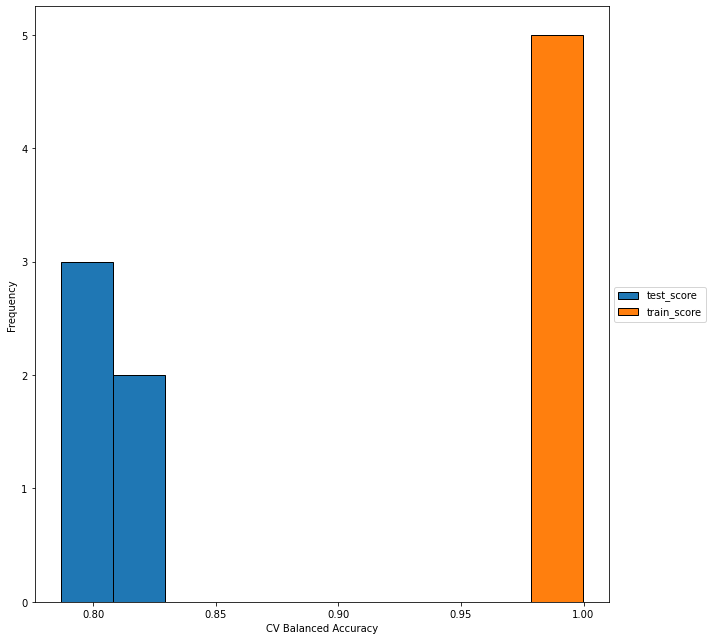

In [60]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV Balanced Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [61]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [62]:
pipe[1]

RandomForestClassifier(max_samples=0.66, random_state=42)

In [63]:
param_grid = {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__max_features': ['sqrt', 'log2',],
    'clf__max_depth': [None, 10, 20],
    'clf__max_samples':[0.66],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': ['balanced','balanced_subsample', None],
    'clf__criterion' :['gini', 'entropy']
}

In [64]:
pipe_1 = Pipeline([('preprocessing', preprocessing), ('clf',RandomForestClassifier(random_state = 42))])

In [65]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [66]:
random_search = RandomizedSearchCV(estimator=pipe_1, param_distributions=param_grid, n_iter=50,
                                   scoring=make_scorer(balanced_accuracy_score), n_jobs=-1, cv=inner_cv, random_state=42)

In [72]:
# Fit the random search to your data
cv_random_search = cross_validate(random_search, X_train, y_train , cv=outer_cv, scoring = scorer, return_estimator = True)


/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [73]:
cv_random_search['test_score'].mean(), cv_random_search['test_score'].std()

(0.845473053435194, 0.012783498794802787)

In [75]:
#cv_random_search

In [76]:
for estimator in cv_random_search["estimator"]:
    print(estimator.best_params_, estimator.best_score_)

{'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.66, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'} 0.8261402488604475
{'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.66, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'} 0.8277353951239796
{'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.66, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'} 0.8259153368929641
{'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.66, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'} 0.8359827167356

In [77]:
pipe_rm = Pipeline([('preprocessing', preprocessing), ('clf',RandomForestClassifier(n_estimators= 400, min_samples_split= 2,
 min_samples_leaf= 2, max_features='sqrt', max_depth= None, criterion = 'gini', max_samples = 0.66, class_weight= 'balanced_subsample',random_state = 42))])

In [78]:
pipe_rm.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['category']),
                                                 ('num', StandardScaler(),
                                                  ['mrgn_0', 'mrgn_1', 'mrgn_2',
                                                   'mrgn_3', 'mrgn_4', 'mrgn_5',
                                                   'mrgn_6', 'mrgn_7', 'mrgn_8',
                                                   'mrgn_9', 'mrgn_10',
                                                   'mrgn_11', 'mrgn_12',
                                                   'mrgn_13', 'mrgn_14',
                                                   'mrgn_15', 'mrgn_16',
                                                   'mrgn_17', 'mrgn_18',
                                                   'mrgn_19', 'mrgn_20',
                                                   'mrgn_21', 'mrgn_22',
                                                   'mrgn_23', 'mrgn_24',
                                                   'mrgn_25', 'mrgn_26',
                                                   'mrgn_27', 'mrgn_28',
                                                   'mrgn_29', ...])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_samples=0.66, min_samples_leaf=2,
                                        n_estimators=400, random_state=42))])

In [79]:
preds = pipe_rm.predict(X_test)

In [80]:
balanced_accuracy_score(y_test, preds)

0.856871722141845

In [81]:
from sklearn.metrics import recall_score, accuracy_score
unique_classes = set(y_test)

# Initialize a dictionary to store the balanced accuracy scores for each class
balanced_accuracy_scores = {}
recall_scores = {}
# Compute balanced accuracy for each class
for cls in unique_classes:
    # Create binary labels for the current class
    y_true_cls = [1 if y == cls else 0 for y in y_test]
    y_pred_cls = [1 if y == cls else 0 for y in preds]
    
    # Compute recall (sensitivity) for the current class
    recall = recall_score(y_true_cls, y_pred_cls)
    
    # Compute specificity (true negative rate) for the current class
    tn = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == pred == 0)
    fp = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == 0 and pred == 1)
    specificity = tn / (tn + fp)
    
    # Compute balanced accuracy for the current class
    balanced_accuracy = (recall + specificity) / 2
    
    # Store the balanced accuracy score for the current class
    balanced_accuracy_scores[cls] = balanced_accuracy
    recall_scores [cls] = recall


In [82]:
recall_scores['Category1']

0.9743589743589743

In [83]:
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report


In [84]:
matthews_corrcoef(y_test, preds)

0.8871636270063268

In [85]:
confusion_matrix(y_test, preds)

array([[114,   0,   0, ...,   0,   0,   0],
       [  0,  35,   0, ...,   0,   0,   0],
       [  0,   0,  10, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  50,   0,   0],
       [  0,   0,   0, ...,   0,   5,   0],
       [  0,   0,   0, ...,   0,   0,   2]])

In [86]:
report = (classification_report(y_test, preds))

/home/gpatlewi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
#report

In [90]:
report = report.split('\n')

In [91]:
test = pd.DataFrame(report)

In [92]:
test

,0
0,precision recall f1-score ...
1,
2,Category1 0.97 0.97 0.97 ...
3,Category10 0.78 0.88 0.82 ...
4,Category100 0.77 0.83 0.80 ...
...,...
120,
121,accuracy 0.89 ...
122,macro avg 0.83 0.86 0.83 ...
123,weighted avg 0.90 0.89 0.89 ...


In [93]:
result_df = test[0].str.split(expand=True)

In [94]:
 result_df.iloc[0,:].tolist()

['precision', 'recall', 'f1-score', 'support', None, None]

In [95]:
result_df.columns = ['Category', 'precision', 'recall', 'f1-score', 'support', 'untitled']

In [96]:
result_df = result_df.iloc[2:,:]

In [97]:
result_df.to_csv(external_dir+'cr2.csv')

In [98]:
report_df = pd.read_csv(external_dir+'cr2.csv', index_col = [0])

In [99]:
report_df

,Category,precision,recall,f1-score,support
2,Category1,0.97,0.97,0.97,117.0
3,Category10,0.78,0.88,0.82,40.0
4,Category100,0.77,0.83,0.80,12.0
5,Category101,1.00,0.50,0.67,20.0
6,Category102,1.00,1.00,1.00,2.0
...,...,...,...,...,...
119,Category99,0.67,1.00,0.80,2.0
121,accuracy,NaN,NaN,0.89,3105.0
122,macro_avg,0.83,0.86,0.83,3105.0
123,weighted_avg,0.90,0.89,0.89,3105.0


In [100]:
report_df = report_df.iloc[:-1, :]

In [101]:
reverse_dict = {v:k for k,v in my_dict.items()}

In [102]:
report_df['terminal_category'] = report_df['Category'].replace(reverse_dict)

/tmp/ipykernel_3387816/4033952111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_df['terminal_category'] = report_df['Category'].replace(reverse_dict)


In [103]:
#report_df.to_csv(external_dir+'classification_performance_140524.csv')

In [104]:
report_df =  pd.merge(report_df, pd.DataFrame(list(balanced_accuracy_scores.items()), columns = ['Category', 'BA']), on = 'Category', how = 'left' )

In [105]:
report_df.sort_values(by = 'BA', ascending = False).head(10)

,Category,precision,recall,f1-score,support,terminal_category,BA
10,Category108,1.0,1.0,1.0,6.0,"('others, cyclic', 'lt7', 3.0, 3.0)",1.0
63,Category5,1.0,1.0,1.0,18.0,"('Aromatic PFASs', 'lt7', 2.0, 3.0)",1.0
75,Category60,1.0,1.0,1.0,3.0,"('PFAAs, cyclic', 'lt7', 2.0, nan)",1.0
60,Category47,1.0,1.0,1.0,4.0,"('PFAA precursors, cyclic', 'lt7', 1.0, 1.0)",1.0
4,Category102,1.0,1.0,1.0,2.0,"('others, cyclic', 'lt7', 2.0, 1.0)",1.0
107,Category9,1.0,1.0,1.0,12.0,"('Aromatic PFASs', 'lt7', 4.0, 1.0)",1.0
6,Category104,1.0,1.0,1.0,2.0,"('others, cyclic', 'lt7', 2.0, 3.0)",1.0
7,Category105,1.0,1.0,1.0,3.0,"('others, cyclic', 'lt7', 2.0, 4.0)",1.0
101,Category84,1.0,1.0,1.0,4.0,"('Polyfluoroalkyl acids, cyclic', 'lt7', 5.0, ...",1.0
99,Category82,1.0,1.0,1.0,2.0,"('Polyfluoroalkyl acids, cyclic', 'lt7', 4.0, ...",1.0


In [146]:
report_df.sort_values(by = 'BA', ascending = False).tail(10)

,Category,precision,recall,f1-score,support,terminal_category,BA
39,Category28,0.67,0.40,0.50,5.0,"('Other PFASs, cyclic', 'lt7', 3.0, 2.0)",0.699839
21,Category118,0.80,0.40,0.53,10.0,misc_category,0.699838
14,Category111,0.20,0.33,0.25,3.0,"('unclassified', 'lt7', 1.0, 2.0)",0.666022
15,Category112,0.50,0.31,0.38,13.0,"('unclassified', 'lt7', 1.0, 3.0)",0.653199
19,Category116,1.00,0.25,0.40,4.0,"('unclassified', 'lt7', 3.0, 3.0)",0.625000
17,Category114,0.20,0.25,0.22,4.0,"('unclassified', 'lt7', 3.0, 1.0)",0.624355
16,Category113,0.00,0.00,0.00,3.0,"('unclassified', 'lt7', 2.0, 3.0)",0.499516
118,accuracy,NaN,NaN,0.89,3105.0,accuracy,NaN
119,macro_avg,0.84,0.86,0.84,3105.0,macro_avg,NaN
120,weighted_avg,0.90,0.89,0.89,3105.0,weighted_avg,NaN


In [106]:
report_df1 = report_df.iloc[:-3, :]

In [107]:
report_df1.to_csv(external_dir+'classification_performance_150524.csv')

In [108]:
report_df2 = report_df1.iloc[:118,:].melt(id_vars=['terminal_category'], value_vars=['recall','BA'], var_name='metric', value_name='value')

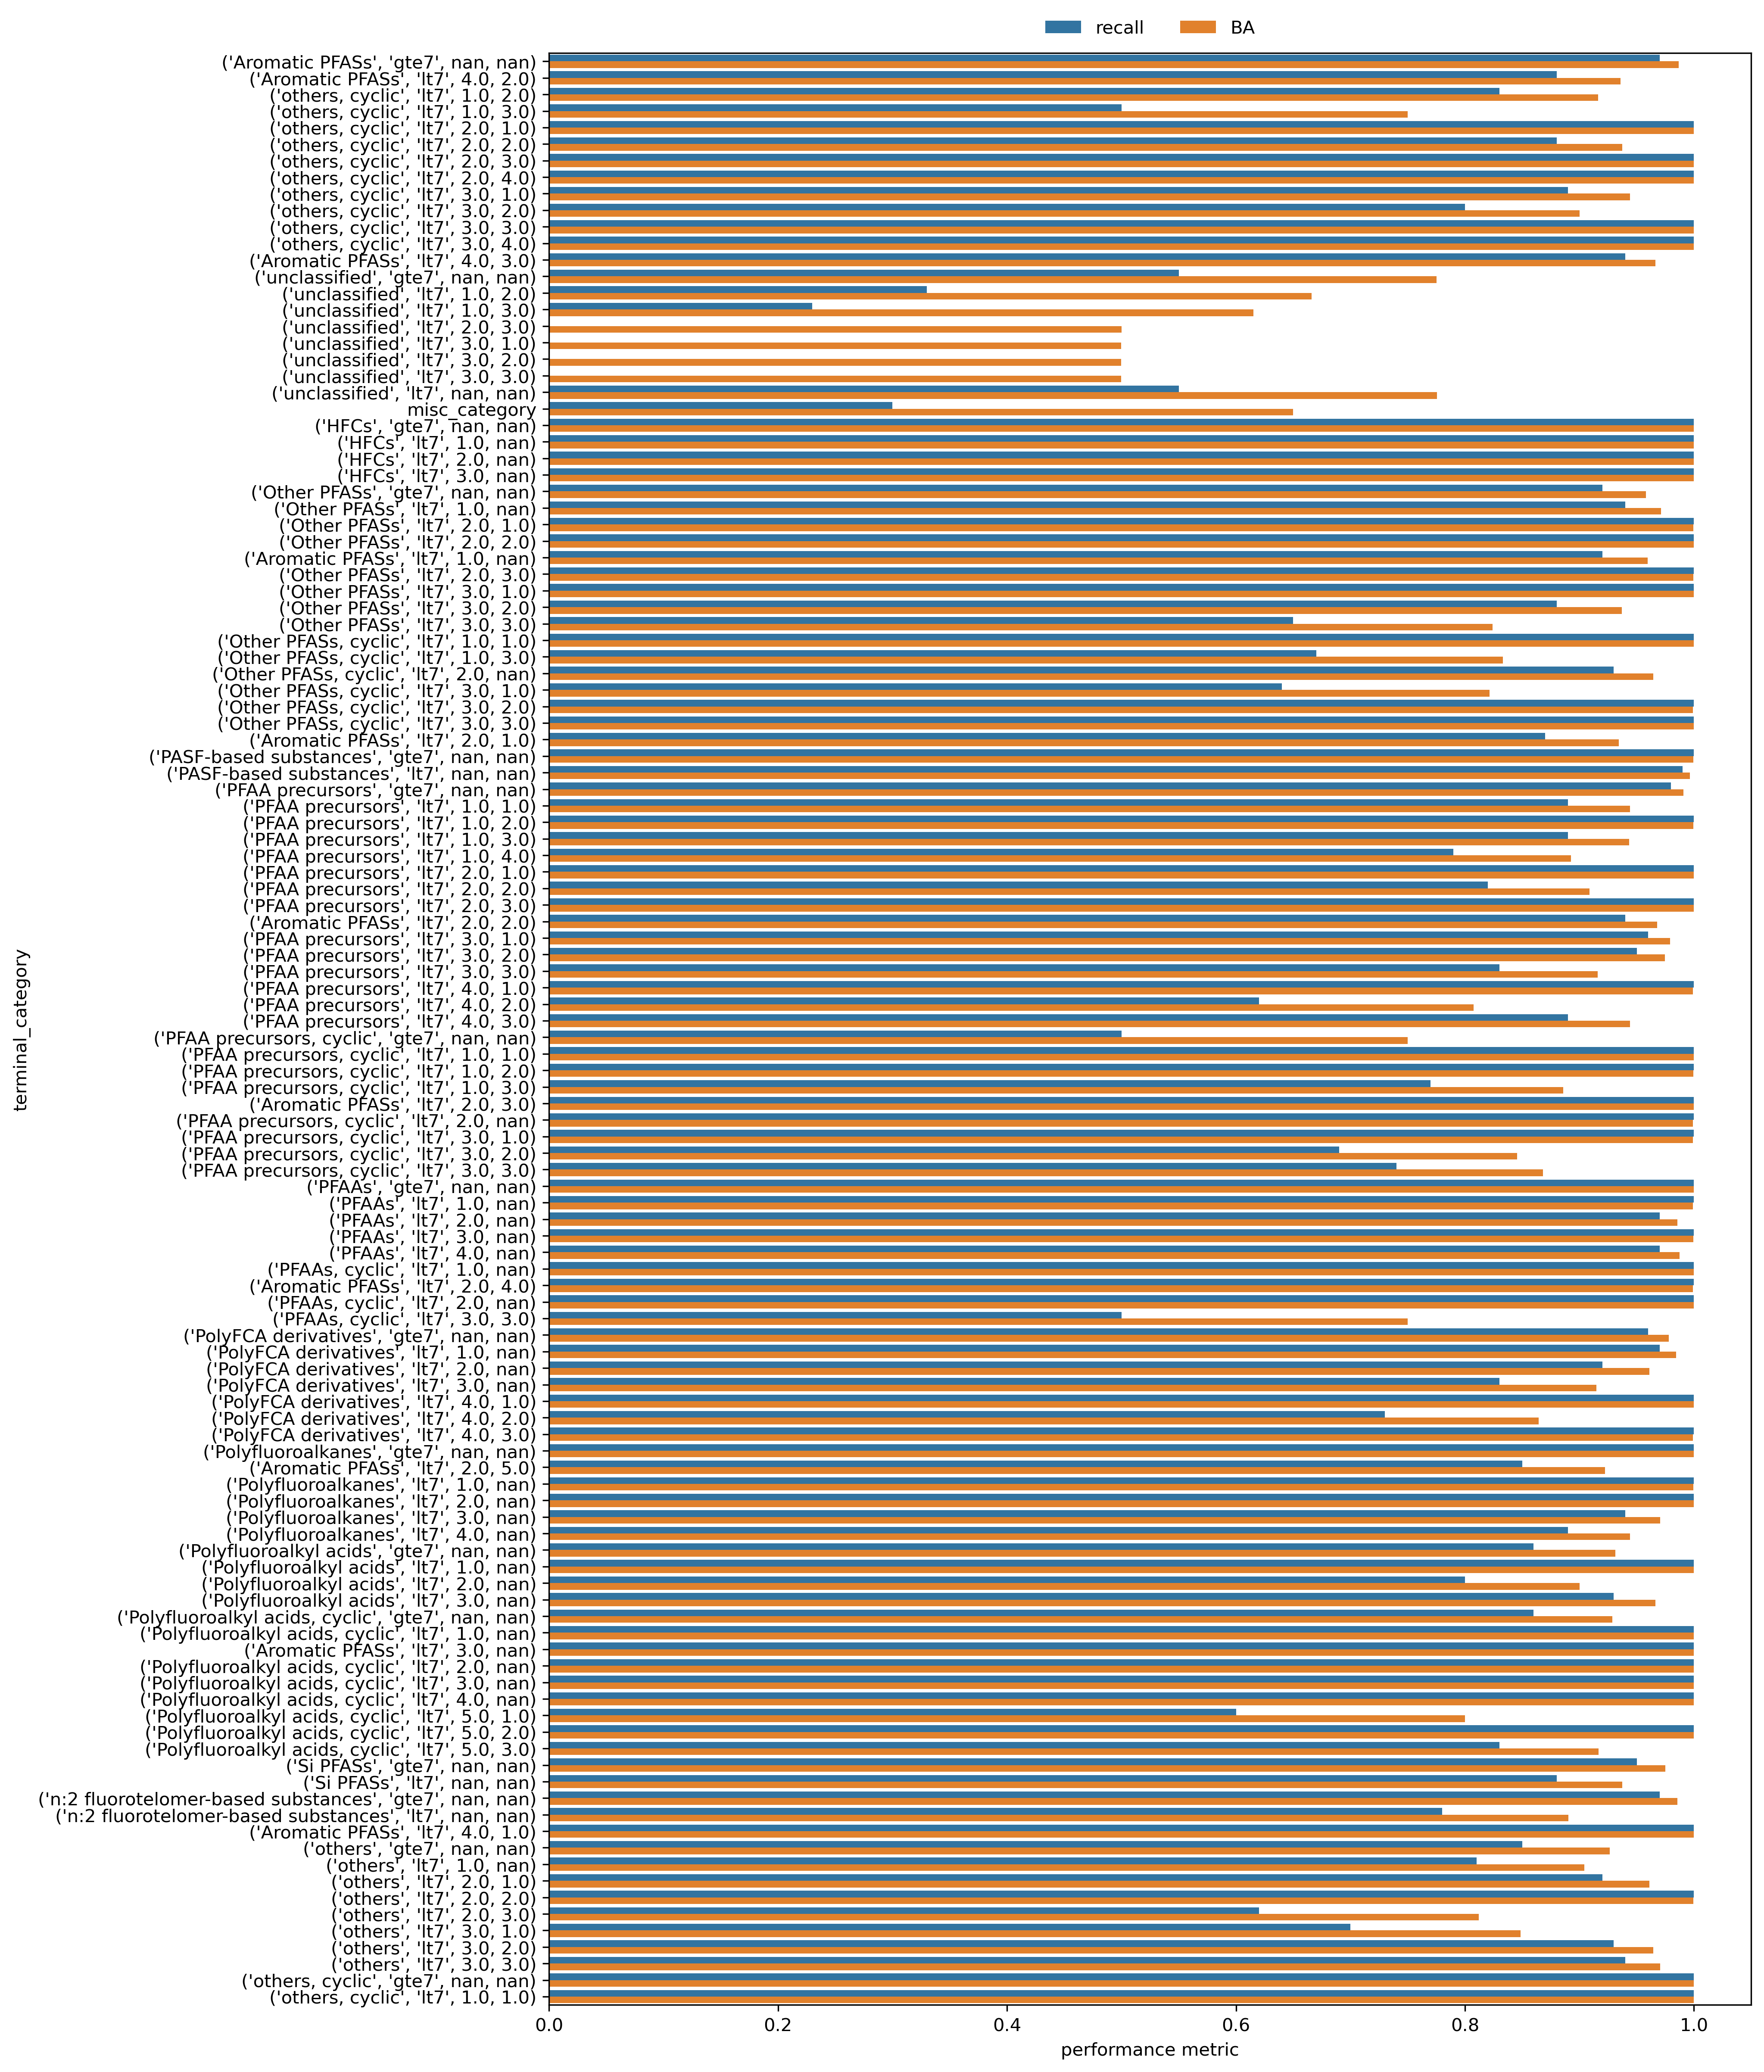

In [109]:
fig,ax = plt.subplots(figsize=(12, 20), dpi=300)
p = sns.barplot(ax=ax, data=report_df2, y='terminal_category', x='value', hue='metric', orient='h')
sns.move_legend(ax, "lower center",bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, fontsize=10 )
ax.set_xlabel('performance metric')
fig.savefig(figures_dir+'classification_rfc_150524.png')

In [110]:
pipe_rm.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['category']),
                                                 ('num', StandardScaler(),
                                                  ['mrgn_0', 'mrgn_1', 'mrgn_2',
                                                   'mrgn_3', 'mrgn_4', 'mrgn_5',
                                                   'mrgn_6', 'mrgn_7', 'mrgn_8',
                                                   'mrgn_9', 'mrgn_10',
                                                   'mrgn_11', 'mrgn_12',
                                                   'mrgn_13', 'mrgn_14',
                                                   'mrgn_15', 'mrgn_16',
                                                   'mrgn_17', 'mrgn_18',
                                                   'mrgn_19', 'mrgn_20',
                                                   'mrgn_21', 'mrgn_22',
                                                   'mrgn_23', 'mrgn_24',
                                                   'mrgn_25', 'mrgn_26',
                                                   'mrgn_27', 'mrgn_28',
                                                   'mrgn_29', ...])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_samples=0.66, min_samples_leaf=2,
                                        n_estimators=400, random_state=42))])

In [111]:
import pickle

In [113]:
filename = 'final_model_v2.sav'
pickle.dump(pipe_rm, open(external_dir+filename, 'wb'))

In [120]:
len(pipe_rm[1].feature_importances_)

1026

In [121]:
features = list(X.columns)

In [122]:
feature_importances1 = pd.DataFrame({'feature': features, 'importance': pipe_rm[1].feature_importances_})
feature_importances1.head()

,feature,importance
0,mrgn_0,0.059818
1,mrgn_1,0.000396
2,mrgn_2,0.007530
3,mrgn_3,0.000474
4,mrgn_4,0.000256


In [132]:
feature_importances1.sort_values(by='importance', ascending = False).to_csv(external_dir+'feature_importances1.csv')

In [130]:
feature_importances1[feature_importances1['feature']== 'category']

,feature,importance
1024,category,0.002772
